# Restricted Structural Causal Models

by Jonas Peters, Niklas Pfister and Rune Christiansnen, 20.06.2019

This notebook is intended to give you some insight on identifiability of additive noise models and how they could be estimated in practice. The references are sparse and are somewhat biased towards [1]. We do not intend to claim that this is the original reference.


In [1]:
library(mgcv)
library(dHSIC)
source("utils.R")

Loading required package: nlme
This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.


## Two Variables

Assume we are given a sample from a bivaraite distribution over $X$ and $Y$ and want to find out, which variable is the cause and which the effect, i.e., whether the distribution has been induced by an SCM with graph $X \rightarrow Y$ or $Y \rightarrow X$. 

Without further assumptions, this will not be possible: Either graph can induce any distribution (e.g., see Proposition 4.1 in [1]). This is different, however, if we restrict the model class. E.g., if we consider only linear assignments, we have the following statement:

Given a distribution over $X$ and $Y$ that is induced by an SCM with linear assignments and graph $X \rightarrow Y$, then it is also induced by an SCM with linear assignments and graph $X \leftarrow Y$ only if the noise variables are Gaussian (e.g., see [2] or Thm 4.2. in [1]). 


### Exercise 1: 
Generate a (large) sample from a distribution from a linear SCM with graph $X \rightarrow Y$ and non-Gaussian noise (e.g., uniform). Do the same for a linear SCM with the reversed graph $X \leftarrow Y$. Plot both samples. What is the (systematic) difference between the two pictures?

### Solution 1: 

In [2]:
set.seed(1)
ny <- runif(n = 1000)
X <- runif(n = 1000)
y <- 2*X + ny

### End of Solution 1

A very similar statement holds for nonlinear functions, too: If a distribution is induced by $Y = f(X) + N_Y$ with $N_Y$ independent of $X$, then only for very few (and somewhat non-generic) combinations of functions $f$ and distributions of $X$ and $N_Y$, will we find a model in the backward direction, too (e.g., see Thm 4.5 in [1]).

But how can we find the graph if we are only given a sample from the joint (observational) distribution? In other words, how do we decide which model the data come from:
$$ \tag{1}
Y = f(X) + N_Y, \quad N_Y \text{ indep. } X 
$$
or
$$ \tag{2}
X = g(Y) + N_X, \quad N_X \text{ indep. } Y ?
$$


Let us consider a real world data set. 

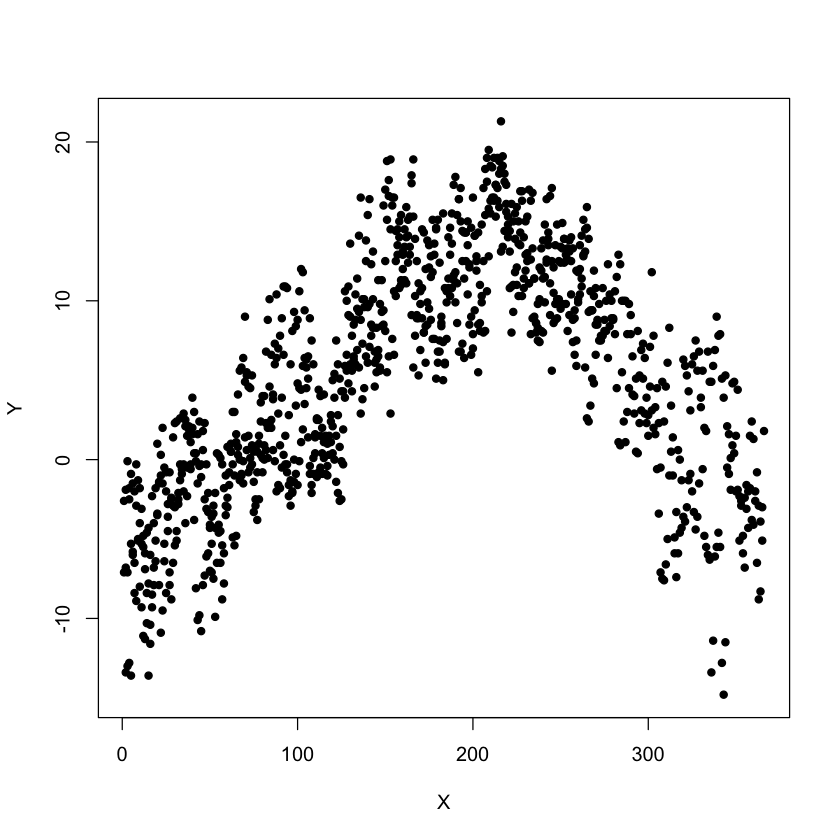

In [14]:
XX <- read.csv('./RestrictedSCMsData1.txt', sep = "\t")
XX <- XX[1:1000,]
Y <- XX[,2]
X <- XX[,1]
plot(X, Y, pch = 19, cex = .8)

The next two exercises contain two approaches that aim to estimate the underlying causal DAG, i.e., whether $X \rightarrow Y$ or $X \leftarrow Y$.


### Exercise 2: 

First, we perform an approach based on independence tests. If (1) is correct, then $Y-f(X)$ is independent of $X$. If (1) is incorrect, then $Y-f(X)$ is dependent on $X$ for all choices of $f$. We can thus verify (1) by estimating the regression of $Y$ on $X$ and checking if the residuals are independent of $X$. More formally, we follow the following procedure.

1. Regress $Y$ on $X$ and obtain estimate $\hat{f}$.
2. Check whether the residuals $Y - \hat{f}(X)$ are independent of $X$. 
3. Repeat the same in the opposite direction.
4. If the independence is accepted for one direction and rejected for the other, infer the former one as the causal direction. 

To regress B on A, you may use ```gam(B ∼ s(A))``` from package ```mgcv```; the residuals can be accessed by ```gam(B ∼ s(A))$residuals```. For the independence test you can use ```dhsic.test``` from package ```dHSIC``` (setting ```method = "gamma"``` will increase the speed). 

### Solution 2: 

### End of Solution 2 

### Exercise 3: 

If we know the distribution of the noise variables, we can also choose 
a maximum likelihood (ML), also called score-based approach. (This means --- roughly--- that we are choosing the model class that is closer to the observed empirical distribution in KL distance.) 
Given a data set, each possible DAG over variables $(X,Y)$ induces a different likelihood function, different maximum likelihood estimates, and therefore a different likelihood score. We can then choose the graph that obtains the highest score. 

Assume that all noise variables are Gaussian with zero mean and a certain variance $\sigma^2$. In this case, it can be shown that the likelihood score for DAG $\mathcal{G}$ is proportional to 
$$
- \log(\mathrm{var}(R^{\mathcal{G}}_X)) - \log(\mathrm{var}(R^{\mathcal{G}}_Y)),
$$
where $R^{\mathcal{G}}_X$ and $R^{\mathcal{G}}_Y$ are the residuals obtained from regressing $X$ and $Y$ on their parents in $\mathcal{G}$, respectively.

For any given graph $\mathcal{G}$, we obtain thus obtain a score propotional to the likelihood score by the following three steps.

1. Regress each node on its parents.
2. Compute the variance of all residuals (here: $R_X^\mathcal{G}$ and $R_Y^\mathcal{G}$).
3. Calculate the above score.

Compute this score for all graphs (here: $X \rightarrow Y$, $X \leftarrow Y$ and the empty graph $X \quad Y$) and compare.

### Solution 3:

### End of Solution 3

In fact, the example shows for several days of the year the average daily temperature in a city in Germany. The value of $X$ indicates the altitude and the value of $Y$ the annual mean temperature. We expect that $X \rightarrow Y$ is the underlying causal structure.


Note that there is the following fundamental problem. In almost all scenarios, we'll reject any statistical model if we receive more and more data. The same happens here. In the wrong direction, however, the model is rejected even for small sample sizes.


## More than two Variables

So far, we have considered two variables but the same principle applies to more than two variables, too. Again, one can show that without further assumptions, it is not possible to infer causal structure from just observational data, see Proposition 7.1 in [1].

We will now see how the approaches from above can be generalized to problems that contain more than two variables.


In [15]:
load(file = "./RestrictedSCMsData2.RData")             # loads dat

We have now loaded a sample from a distribution over variables $W$, $X$, $Y$, and $Z$. The columns of the matrix ```dat``` contain the data for the variables $W$, $X$, $Y$, and $Z$, respectively. 

In principle, we can now go through all DAGs and for each DAG --- as before --- compute the residuals and consider either their independence or the likelihood score (details are explained below). The problem, however, is that for both methods, adding edges usually helps. To be able to detect and remove "inactive" edges, we have to slightly modify the procedure. First, to make your life easier, we load some DAGs over four variables.


In [16]:
load(file = "./RestrictedSCMsallDagsWith4Nodes.RData") # loads all DAGs as allDags
load(file = "./RestrictedSCMsallFullDagsWith4Nodes.RData") # loads all fully connected DAGs as allFullDags

The matrix ```allDags``` has dimension 543x16 and contains all 543 directed acyclic graphs (DAGs) with four nodes. You can access the adjacency matrix of the 5th DAG by ```matrix(allDags[5,],4,4)```. Similarly for ```allFullDags```. (Can you guess the number of fully connected DAGs over four variables?)



### Exercise 4: 
Go through all fully connected DAGs, and for each DAG, regress each variable on its parents.

1. Independence-based approach: 
Test whether the residuals are jointly independent (you test whether the columns of a matrix ```A``` are jointly independent by ```dHSIC::dhsic.test(A, method="gamma", matrix.input=TRUE)```. Output the DAG with the largest $p$-value.
2. Score-based approach: Similarly to exercise 3, compute the residuals for each of the four regressions and calculate the score
$$
- \log(\mathrm{var}(R_W)) - \log(\mathrm{var}(R_X)) - \log(\mathrm{var}(R_Y)) - \log(\mathrm{var}(R_Z)).
$$ 
    and output the DAG with the largest score.

For regressions, you can use the function ```train_gam```, it is a wrapper for the function ```gam```. E.g., ```train_gam(dat[,c(1,3)], dat[,2])``` regresses $X$ on $W$ and $Y$.

Both procedures estimate a fully connected DAG. Do you have an idea how to modify the above procedure to remove "inactive" edges? Which one is the underlying DAG that was used to generate the data? (Hint: to your convenience, the outcome of ```train_gam``` contains an entry ```p.values``` that indicate whether a variable is significant in the regression model or not.) 


### Solution 4: 

You can fill in the missing placess in the following code snippet. Feel free to write alternative solutions.

In [18]:
numDags <- dim(allFullDags)[1]
independence.p.vals <- rep(NA, numDags)
scores <- rep(NA, numDags)
pvals <- array(NA, dim = c(numDags,4,4))

for(j in 1:numDags){
  currentDag <- matrix(allFullDags[j,], 4, 4)
  residual.log.var <- rep(NA, 4)
  residual.matrix <- matrix(NA, dim(dat)[1], dim(dat)[2])
  for(i in 1:4){
      # regress the ith node onto its parents
      # store p-values for regressors and compute log residuals variances
      ###############################
      ## fill in 
      ###############################
  }
    # test for joint independence of residuals
    # compute score
    ################################
    ## fill in 
    ################################
    
    filledInIndep <- all(!is.na(independence.p.vals))
    filledInScores <- all(!is.na(scores))
}

# Now we can choose the maxima as estimates.
if(filledInIndep){
    print("The independence p-values equal")
    show(independence.p.vals)
    Ghat1.num <- which.max(independence.p.vals)
    Ghat1 <- matrix(allFullDags[Ghat1.num, ], 4, 4)
    print(paste("The estimated DAG using independence is number", Ghat1.num, ". It looks like this:"))
    show(Ghat1[])
    print("Considering only significant edges yields")
    show(Ghat1 * (pvals[Ghat1.num,,] < 0.05))

    print("===")
    print("===")
}

if(filledInIndep){
    print("The scores equal")
    show(scores)
    Ghat2.num <- which.max(scores)
    Ghat2 <- matrix(allFullDags[Ghat2.num, ], 4, 4)
    print(paste("The estimated DAG using scores is number", Ghat2.num, ". It looks like this:"))
    show(Ghat2[])
    print("Considering only significant edges yields")
    show(Ghat2 * (pvals[Ghat2.num,,] < 0.05))

    print("===")
    print("===")
}

### End of Solution 4

To deal with "inactive edges", there are alternatives to consider fully connected DAGs. E.g., for the score-based approach, you may also go through all DAGs and compute the score 
$$
- \log(\mathrm{var}(R_W)) - \log(\mathrm{var}(R_X)) - \log(\mathrm{var}(R_Y)) - \log(\mathrm{var}(R_Z)) - \log(n) \cdot \# \text{pars}/2,
$$ 
where $\# \text{pars}$ are the number of parameters. Adding edges always makes the residuals smaller and therefore the first part of the score larger. The "penalization term" compensates for that effect. The score is called Bayesian Information Criterion (BIC).


## References

[1] J. Peters, D. Janzing, B. Schölkopf: ``Elements of Causal Inference: Foundations and Learning Algorithms'', to appear at MIT Press.

[2] S. Shimizu, P. O. Hoyer, A. Hyvärinen, and A. J. Kerminen. A linear non-Gaussian
acyclic model for causal discovery. Journal of Machine Learning Research, 7:
2003–2030, 2006.
